In [1]:
# Launch 4 parallel processes and load module in all
addprocs(4)
import QuantumBayesian
@everywhere using QuantumBayesian

using PyPlot

# One Qubit Stochastic Monitoring Test

**Justin Dressel**, Dec 14, 2016 <br />
*Institute for Quantum Studies, Chapman University*

Using a simple qubit Rabi oscillation problem, test whether the Quantum Bayesian update code for Julia produce sensible results for the simplest quantum problem of monitoring the observable of a single qubit.

## Problem Specification

Consider a qubit orbiting in the x-z plane of the Bloch sphere with unit period, with continuous monitoring of the z and/or y observables.

In [2]:
# Ensure qubit and Bloch coordinate functions are defined on all processes for parallelization
@everywhere q = qubit()
@everywhere x(ρ) = real(expect(ρ, q("x")));
@everywhere y(ρ) = real(expect(ρ, q("y")));
@everywhere z(ρ) = real(expect(ρ, q("z")));

In [3]:
@everywhere Ω  = 2*π;        # Rabi frequency, unit period
τ = 3.0;         # Measurement collapse timescale (given quantum-limited efficiency)
Γ = 1/(2*τ);     # Measurement dephasing rate
T = (0.0, 3*τ);  # Time duration of simulation;

# Hamiltonian: oscillations in x-z plane
H = (Ω/2)*q("y");

# Initial ground state
ρ0 = ground(q);

Below is convenience code for plotting purposes -- it is safe to skip to the next section.

In [4]:
function plot_solution(sol; plot_title="Monitored Rabi Oscillation", readout=false, ymeas=false, stds=[])
    # Plot Bloch components vs. time
    figure(1)
    ax = gca()
    ax[:set_ylim]([-1.1,1.1])
    hold(true)
    plot(sol[1].t, sol[1], label=L"$x$", color="r")
    plot(sol[2].t, sol[2], label=L"$y$", color="g")
    plot(sol[3].t, sol[3], label=L"$z$", color="b")
    if length(stds) > 0
        fill_between(sol[1].t, sol[1]-stds[1], sol[1]+stds[1], color="r", alpha=0.2, antialiased=true)
        fill_between(sol[2].t, sol[2]-stds[2], sol[2]+stds[2], color="g", alpha=0.2, antialiased=true)
        fill_between(sol[3].t, sol[3]-stds[3], sol[3]+stds[3], color="b", alpha=0.2, antialiased=true)
    end
    xlabel(L"$t\,\nu$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    hold(false)
    show()
    if readout
        figure(2)
        hold(true)
        plot(sol[4].t, sol[4], label=L"$r_z$", color="b")
        ymeas && plot(sol[5].t, sol[5], label=L"$r_y$", color="g")
        if length(stds) > 0
            fill_between(sol[4].t, sol[4]-stds[4], sol[4]+stds[4], color="b", alpha=0.2, antialiased=true)
            ymeas && fill_between(sol[5].t, sol[5]-stds[5], sol[5]+stds[5], color="g", alpha=0.2, antialiased=true)
        end
        xlabel(L"$t\,\nu$")
        ylabel("Stochastic Readout")
        title(plot_title*" Readout")
        legend()
        hold(false)
        show()
    end
end;

## Reference Lindblad Dynamics

First we benchmark pure Lindblad dephasing, to get a reference for the average dynamics and calibrate a reference speed.

Note that this Lindblad simulation corresponds to the master equation ($\hbar=1$):
$$ \dot{\rho} = -i[H,\,\rho] + \frac{\Gamma}{4}\left[\sigma_z\,\rho\,\sigma_z^\dagger - \frac{\{\sigma_z^\dagger\sigma_z,\, \rho\}}{2}\right] $$
with a similar dissipation term for $\sigma_y$ if both axes have dephasing.

In [5]:
# Measurement dephasing
DMz = sqrt(Γ/2)*q("z");
DMy = sqrt(Γ/2)*q("y");
@everywhere DM(t) = cos(2*Ω*t).*DMz + sin(2*Ω*t).*DMy;

# Deterministic averaged evolution (Lindblad equation)
function ensemble_average(; Δt=1/10^2, ymeas=false, tmeas=false)
    # Jump/no-jump Lindblad simulation
    inc = lind(Δt, H, DMz)
    ymeas && (inc = lind(Δt, H, DMz, DMy))
    tmeas && (inc = lind(Δt, H, DM))
    # Keep all simulated points
    trajectory(inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt))
end;

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.056487233 s, Steps per second: 15915.100674164727
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.025381496 s, Steps per second: 35419.50403553833


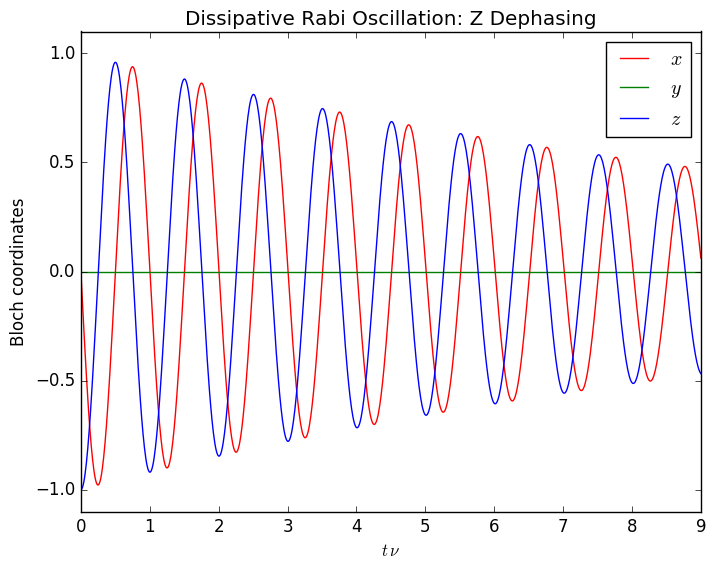

  0.039452 seconds (155.50 k allocations: 11.426 MB)


In [6]:
sol = ensemble_average() # Run once to JIT-compile before timing
@time sol = ensemble_average()
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Z Dephasing")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.060767996 s, Steps per second: 14793.97148459528


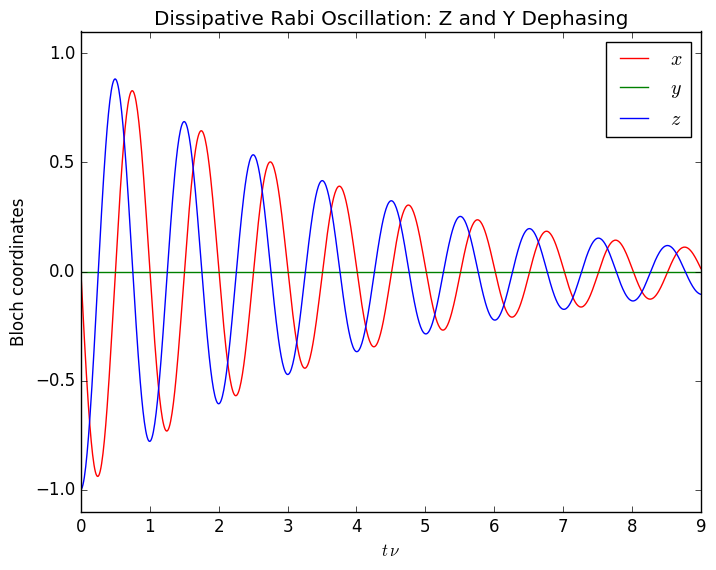

  0.054501 seconds (208.60 k allocations: 15.258 MB)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.05241196 s, Steps per second: 17152.573572902063


In [7]:
sol = ensemble_average(ymeas=true) # Run once to JIT-compile before timing
@time sol = ensemble_average(ymeas=true)
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Z and Y Dephasing")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.19807101 s, Steps per second: 4538.776270187142
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.214881087 s, Steps per second: 4183.7092903388


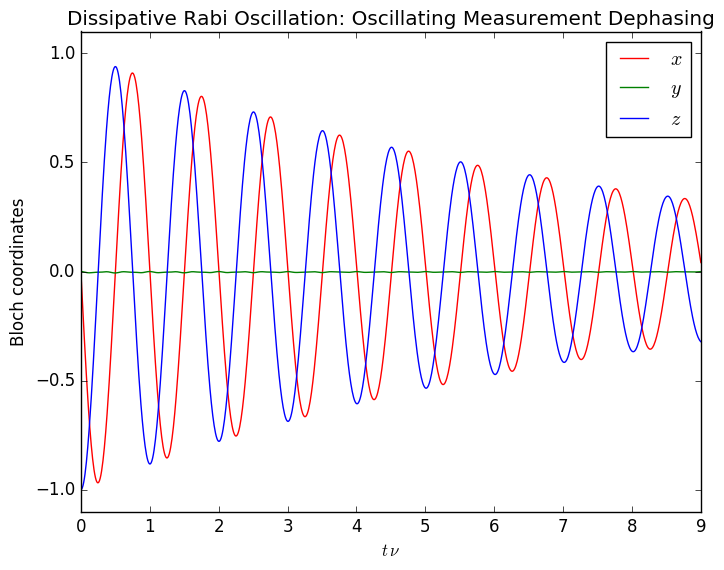

0.216422 seconds (659.86 k allocations: 51.025 MB, 3.19% gc time)


In [8]:
sol = ensemble_average(tmeas=true) # Run once to JIT-compile before timing
@time sol = ensemble_average(tmeas=true)
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Oscillating Measurement Dephasing")

## Stochastic Dynamics Tests

Now we examine single trajectories and ensembles of trajectories carefully, to make sure they agree with the ensemble-averaged Lindblad dynamics.

Note that this simulation corresponds to the stochastic master equation:
$$ d\rho = -i[H,\,\rho]dt + \frac{\Gamma}{4}\left[\sigma_z\,\rho\,\sigma_z^\dagger - \frac{\{\sigma_z^\dagger\sigma_z,\, \rho\}}{2}\right]dt + \sqrt{\frac{\eta\,\Gamma}{4}}\left[\sigma_z\,e^{-i\phi}\,\rho + \rho\,\sigma_z^\dagger\,e^{i\phi} - \langle\sigma_z\,e^{-i\phi} + \sigma_z^\dagger\,e^{i\phi}\rangle\,\rho\right]dW $$

This can be rewritten in an elegant and more useful way for simulation using the collapse time $\tau = 1/(2\,\Gamma\,\eta)$ by defining the collapse operator
$$ A \equiv \sigma_z\,e^{-i\phi} \equiv A_r - i\, A_i $$
whose real (Hermitian) part corresponds to the measured observable, and whose imaginary (anti-Hermitian) part corresponds to the phase back-action. 

This collapse operator produces a single Kraus operator that governs the total back-action from the collected signal:
$$ M_r = \left(\frac{dt}{2\pi\tau}\right)^{1/4}\,\exp\left[ -i\,\frac{dt\,A_i}{2\tau}\, -\, \frac{dt\,(r-A_r)^2}{4\tau} \right] \propto \exp\left[\frac{dt\,A}{2\tau} - \frac{dt\,A_r^2}{4\tau}\right]$$

The signal $r$ is sampled from the probability distribution $P(r\,|\,\rho) = \text{Tr}[\rho\,M_r^\dagger M_r]$. It is easy to show that this results in the approximate moving-mean white-noise relation : 
$$r\,dt = \langle A_r \rangle\,dt + \sqrt{\tau}\,dW$$

In addition to this back-action, there is residual Lindblad dephasing that occurs at the modified rate:
$$ \gamma = \Gamma - \frac{1}{2\tau} = \frac{1-\eta}{2\,\tau\,\eta} $$

Such residual dephasing can be easily modeled separately using the jump/no-jump unraveling of the Lindblad equation:
$$ \rho(t+dt) = \frac{\gamma\,dt}{4}\,\sigma_z\,\rho(t)\,\sigma_z^\dagger + \sqrt{1 - \frac{\gamma\,dt}{4}\sigma_z^\dagger\sigma_z}\,\rho(t)\,\sqrt{1 - \frac{\gamma\,dt}{4}\sigma_z^\dagger\sigma_z} $$

This complete unraveling into exact discrete-step Kraus operators has the enormous benefit of being a valid completely positive map that preserves the properties of the state. Other methods for integrating the stochastic master equation do not converge in precision easily, comparatively.

In [9]:
function ensemble_realization(; Δt=1/10^2, η=1.0, n=1, ymeas=false, tmeas=false, ϕ=0.0)
    # Monitoring with tunable quantum efficiency
    inc = meas(Δt, H, [(exp(-im*ϕ).*q("z"), τ/η, η)])
    ymeas && (inc = meas(Δt, H, [(exp(-im*ϕ).*q("z"), τ/η, η), (exp(-im*ϕ).*q("y"), τ/η, η)]))
    tmeas && (inc = meas(Δt, H, [(t -> cos(2*Ω*t).*exp(-im*ϕ).*q("z") + sin(2*Ω*t).*exp(-im*ϕ).*q("y"), τ/η, η)]))
    # Choose one trajectory or an ensemble, accordingly
    if n==1
        trajectory(inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=true, readout=true)
    else
        ensemble(n, inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=true, readout=true)
    end
end;

### Single Trajectory Examples

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.059063746 s, Steps per second: 15220.842917751948
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.038973899 s, Steps per second: 23066.71960123877


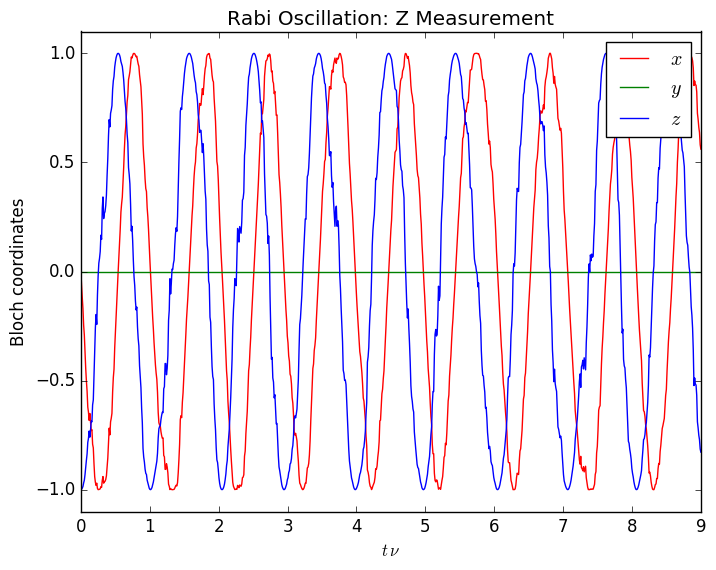

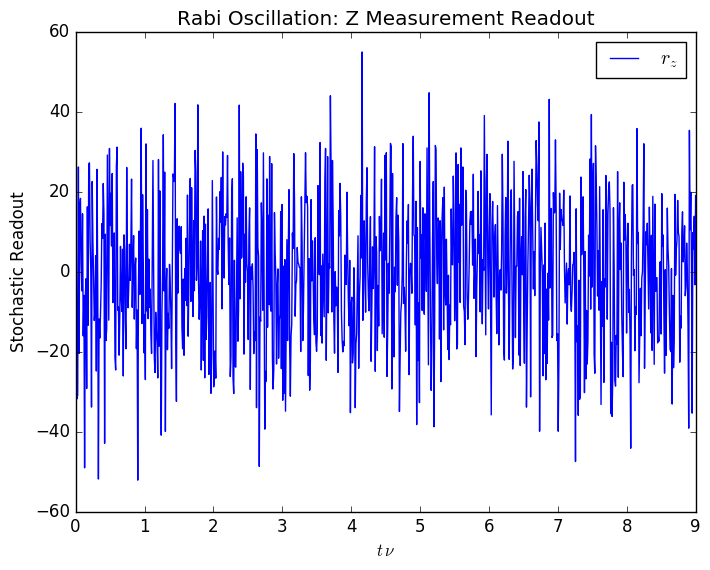

  0.039599 seconds (196.83 k allocations: 14.399 MB, 15.97% gc time)


In [10]:
sol = ensemble_realization() # Run once to JIT-compile before timing
@time sol = ensemble_realization()
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Z Measurement")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1


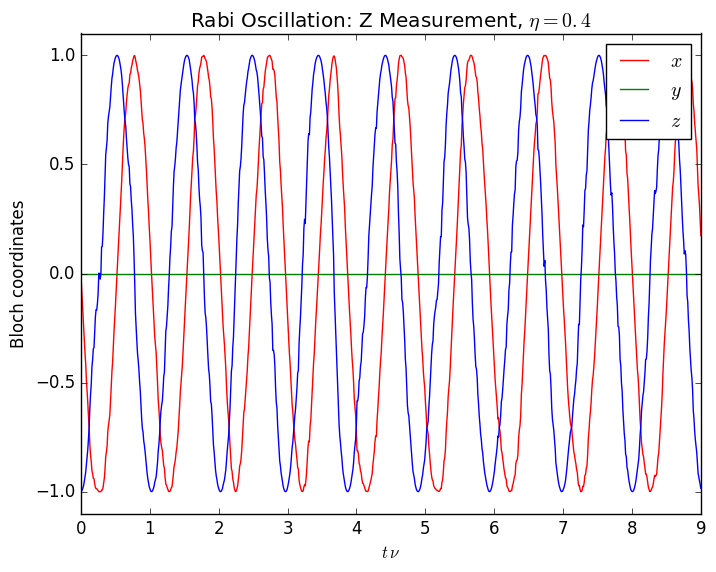

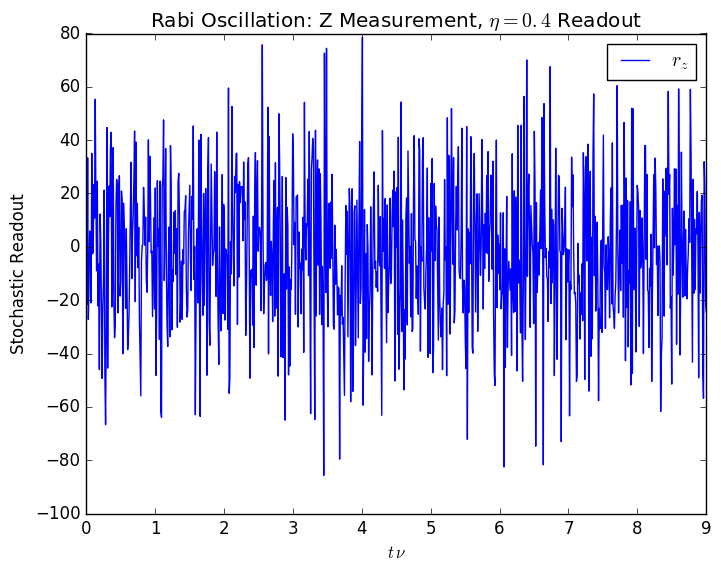

  0.047925 seconds (196.66 k allocations: 14.393 MB, 17.13% gc time)


INFO: Time elapsed: 0.037496024 s, Steps per second: 23975.87541548405
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.047339238 s, Steps per second: 18990.58873740215


In [11]:
sol = ensemble_realization(η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Z Measurement, $\eta=0.4$")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.048831094 s, Steps per second: 18410.400553385105
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.041186655 s, Steps per second: 21827.458432834614


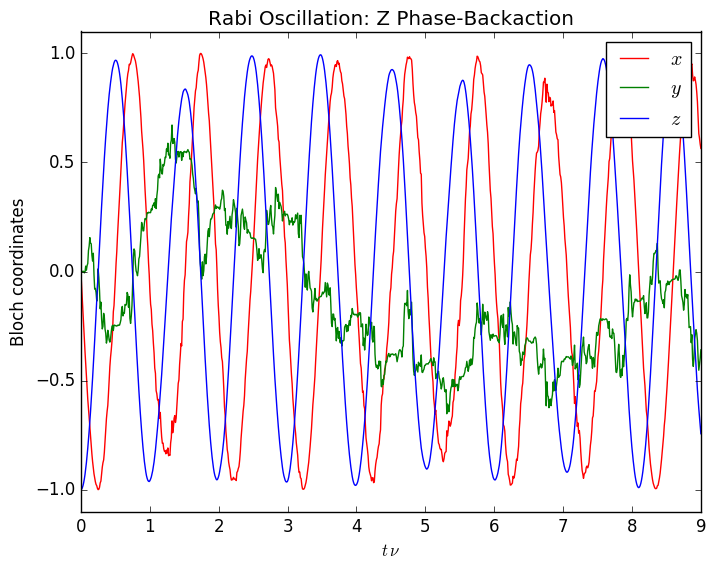

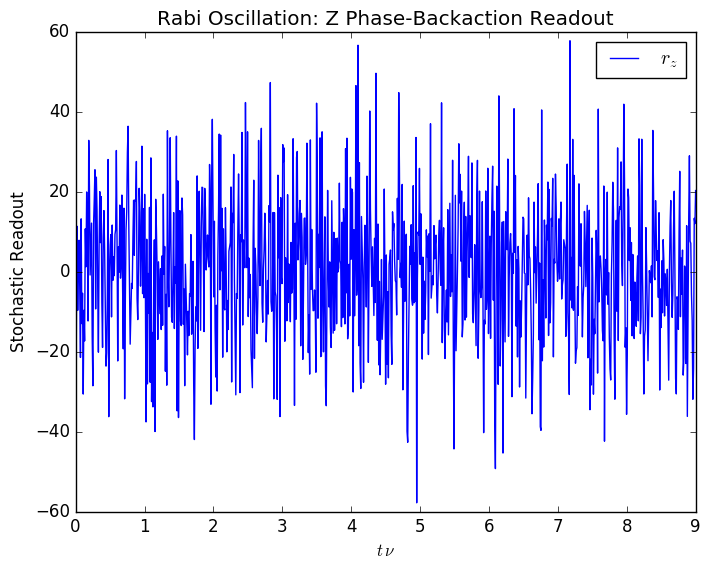

  0.041722 seconds (209.06 k allocations: 14.248 MB)


In [12]:
sol = ensemble_realization(ϕ=π/2) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ϕ=π/2)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Z Phase-Backaction")

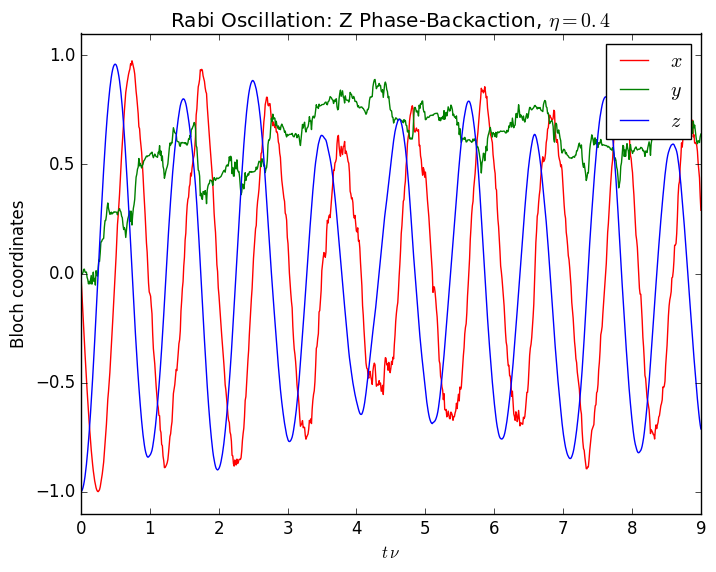

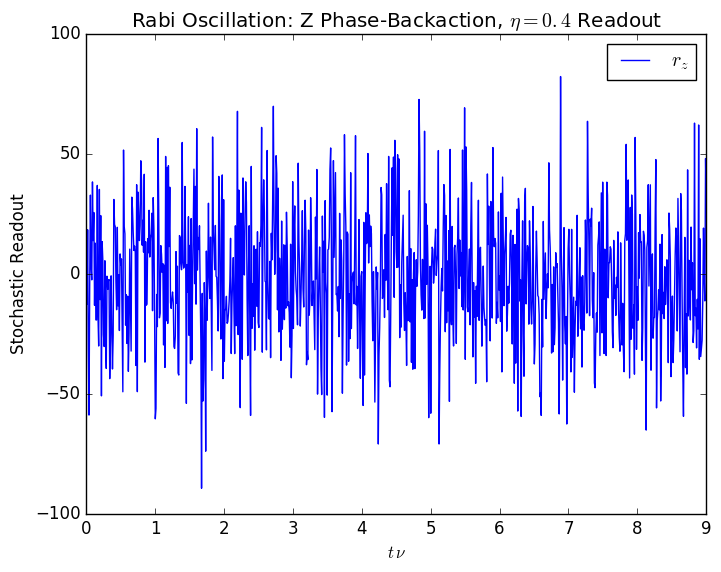

  0.052231 seconds (207.42 k allocations: 14.084 MB, 9.39% gc time)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.038313236 s, Steps per second: 23464.4758276226
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.051427966 s, Steps per second: 17480.761342962698


In [13]:
sol = ensemble_realization(ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Z Phase-Backaction, $\eta=0.4$")

In [14]:
sol = ensemble_realization(ymeas=true) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true)
plot_solution(sol, readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Measurement")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2


  0.069637 seconds (290.90 k allocations: 22.462 MB, 6.59% gc time)


INFO: Time elapsed: 0.074571743 s, Steps per second: 12055.50472382012
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.068942295 s, Steps per second: 13039.8908246382


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.130310828 s, Steps per second: 6898.88947678239
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.133387744 s, Steps per second: 6739.7496429656985


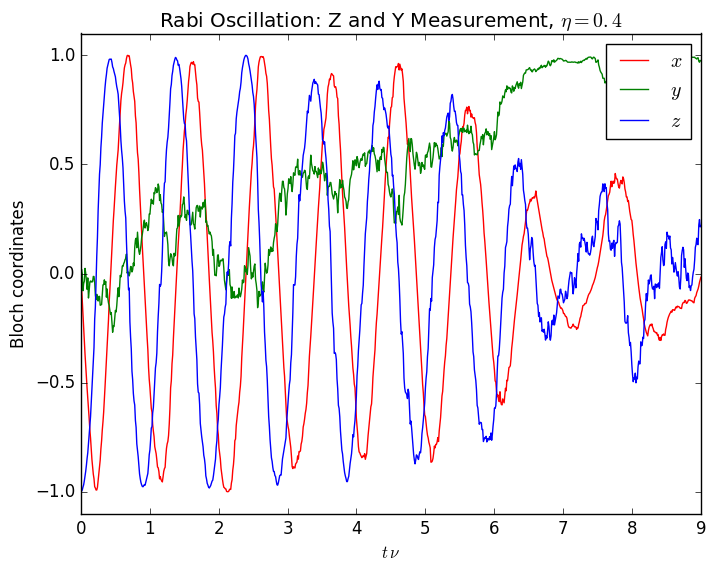

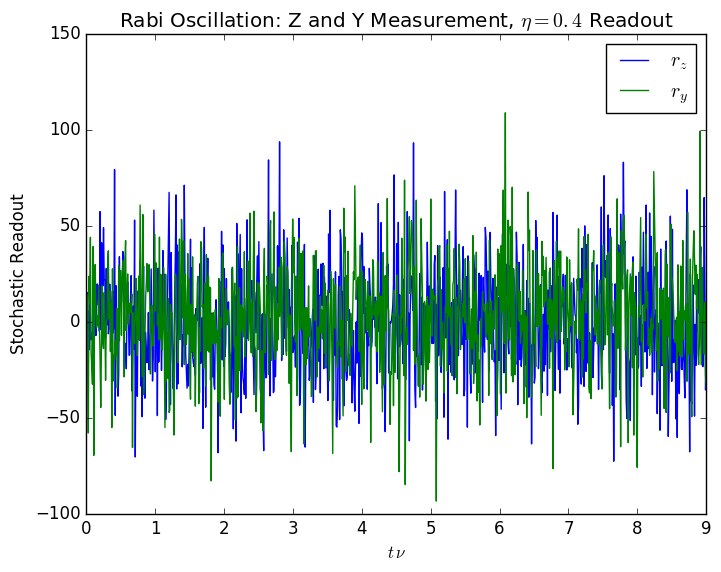

  0.135148 seconds (291.03 k allocations: 22.473 MB, 4.30% gc time)


In [15]:
sol = ensemble_realization(ymeas=true, η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, η=0.4)
plot_solution(sol, readout=true, ymeas=true, plot_title=L"Rabi Oscillation: Z and Y Measurement, $\eta=0.4$")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.063106971 s, Steps per second: 14245.652829700859
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.056715962 s, Steps per second: 15850.916890028242


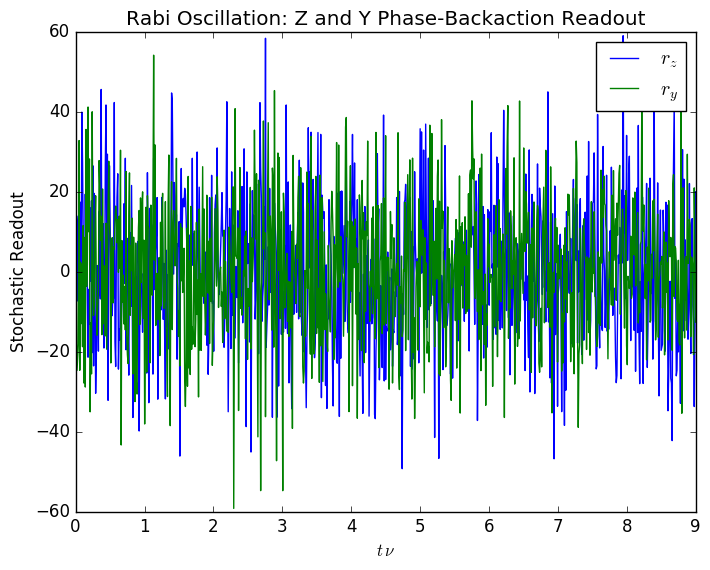

  0.057679 seconds (315.49 k allocations: 22.202 MB, 6.09% gc time)


In [16]:
sol = ensemble_realization(ymeas=true, ϕ=π/2) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, ϕ=π/2)
plot_solution(sol, readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Phase-Backaction")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.066671651 s, Steps per second: 13483.991869347888
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.062292621 s, Steps per second: 14431.885921127


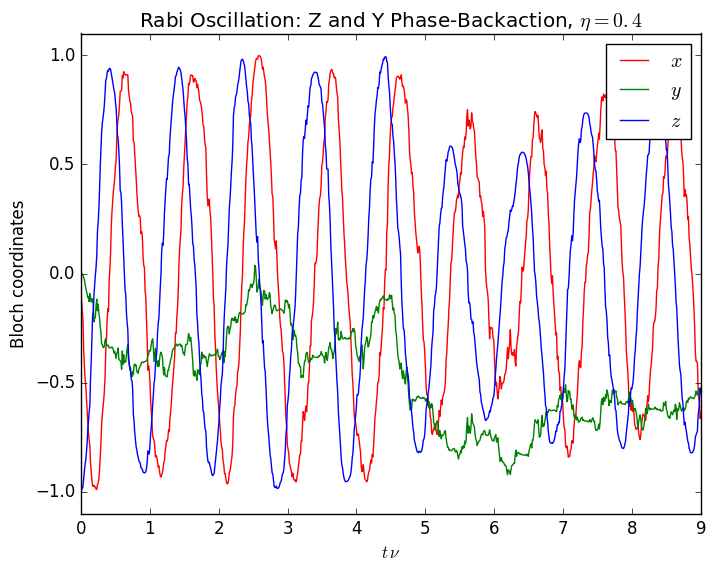

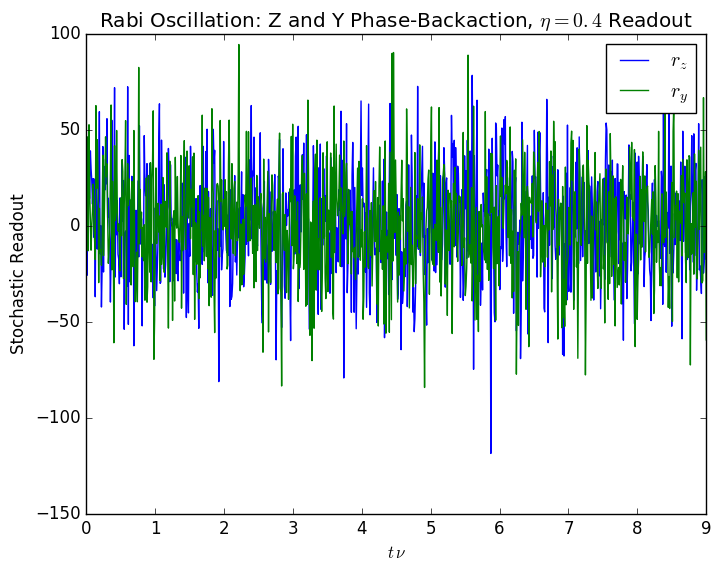

  0.063000 seconds (312.86 k allocations: 21.936 MB, 9.36% gc time)


In [17]:
sol = ensemble_realization(ymeas=true, ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, ymeas=true, plot_title=L"Rabi Oscillation: Z and Y Phase-Backaction, $\eta=0.4$")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.135280252 s, Steps per second: 6645.463670484588
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.158595771 s, Steps per second: 5668.4991934621


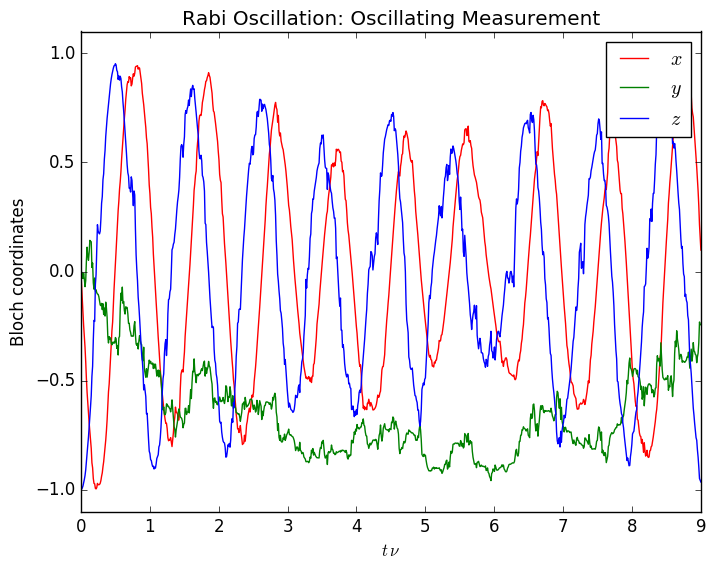

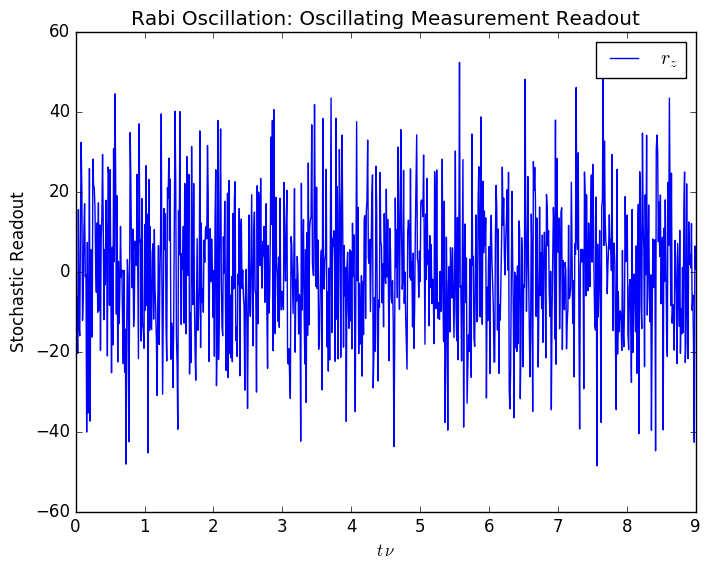

  0.159342 seconds (538.49 k allocations: 33.457 MB, 7.52% gc time)


In [18]:
sol = ensemble_realization(tmeas=true) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Oscillating Measurement")

In [19]:
sol = ensemble_realization(tmeas=true, η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Oscillating Measurement, $\eta=0.4$")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.15729796 s, Steps per second: 5715.268017461893
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.149686156 s, Steps per second: 6005.899436685381


  0.150426 seconds (538.50 k allocations: 33.458 MB, 2.78% gc time)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.160694884 s, Steps per second: 5594.453150107753
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.155252065 s, Steps per second: 5790.583204158992


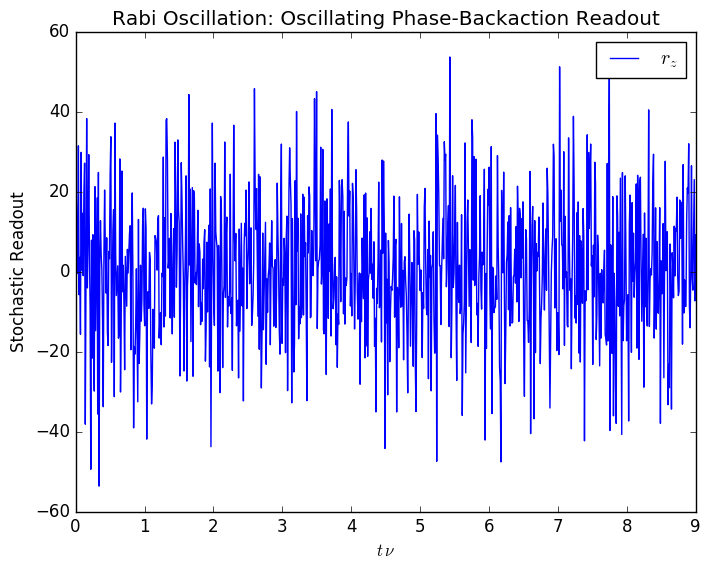

  0.155985 seconds (551.41 k allocations: 33.397 MB, 8.44% gc time)


In [20]:
sol = ensemble_realization(tmeas=true, ϕ=π/2) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true, ϕ=π/2)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Oscillating Phase-Backaction")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.158160855 s, Steps per second: 5684.086621812964
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.15256783 s, Steps per second: 5892.461077803886


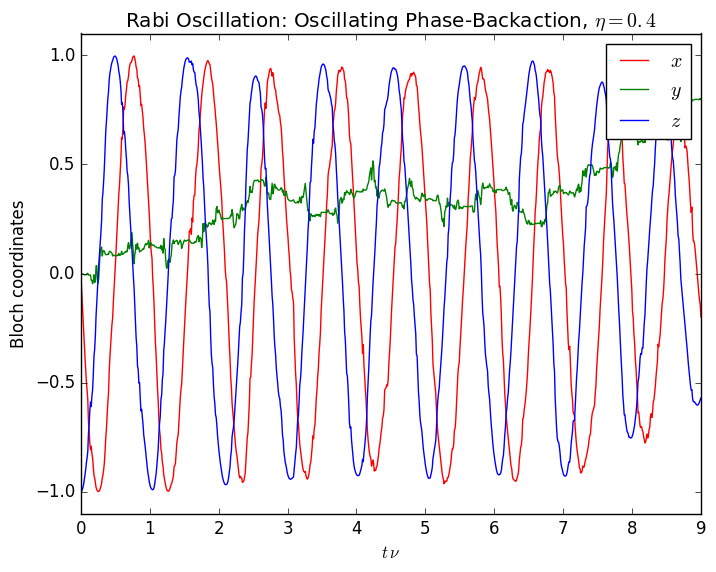

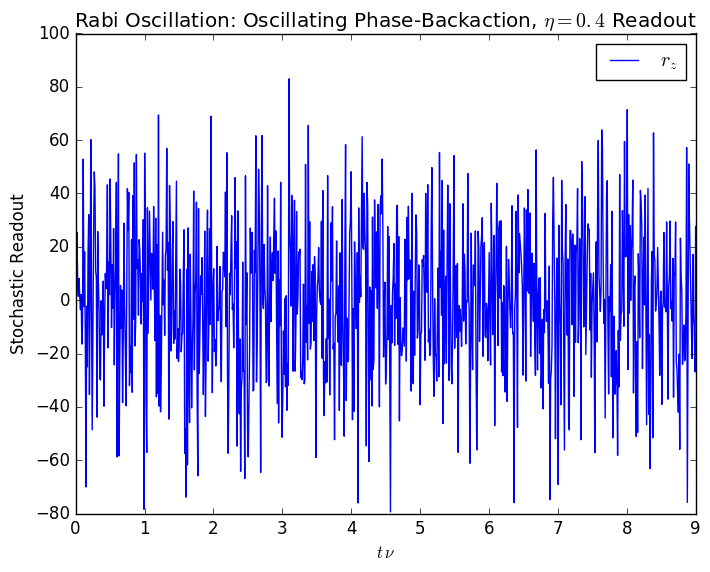

  0.153332 seconds (550.32 k allocations: 33.287 MB, 2.74% gc time)


In [21]:
sol = ensemble_realization(tmeas=true, ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true, ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Oscillating Phase-Backaction, $\eta=0.4$")

### Ensembles of trajectories

In [22]:
# Ensemble size, for easy tunability
num = 2000;

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 5.043315632 s, Steps: 1798, Steps per second: 356.51149584841215
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


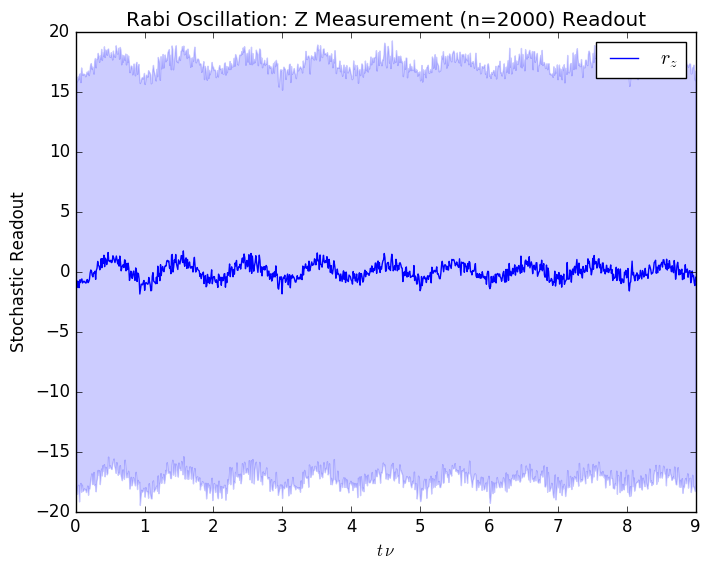

 37.772308 seconds (1.71 M allocations: 156.856 MB, 0.32% gc time)


In [23]:
e = ensemble_realization(n=2) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Z Measurement (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 0.11881065 s, Steps: 1798, Steps per second: 15133.323485731287
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


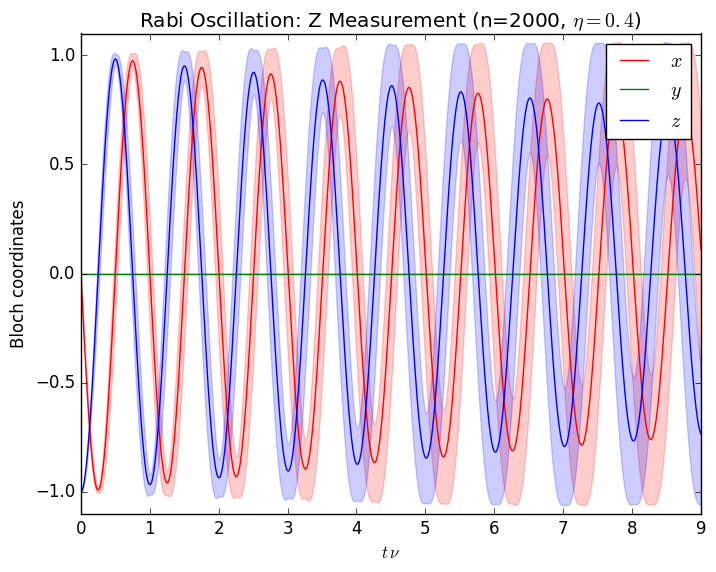

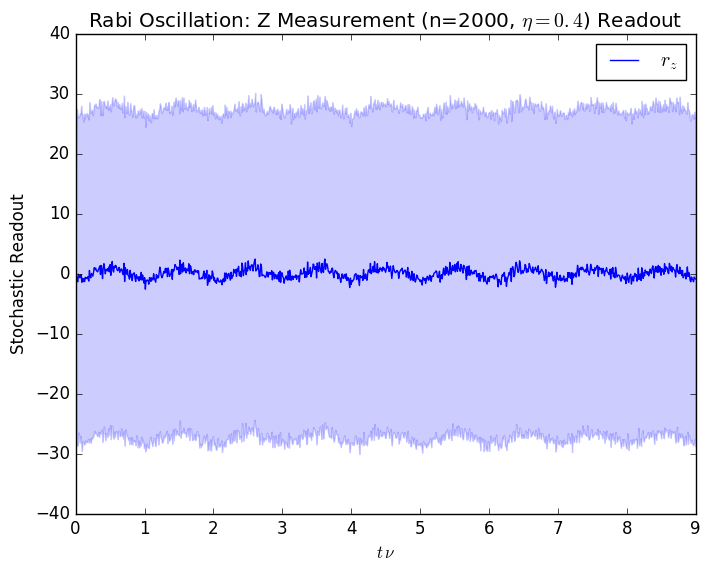

 32.416794 seconds (1.51 M allocations: 147.675 MB, 0.34% gc time)


INFO: Time elapsed: 32.293930686 s, Steps: 1798000, Steps per second: 55676.09646166315


In [24]:
e = ensemble_realization(n=2, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Z Measurement (n=$num, \$\\eta=0.4\$)"))

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 0.099270719 s, Steps: 1798, Steps per second: 18112.088016608403
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


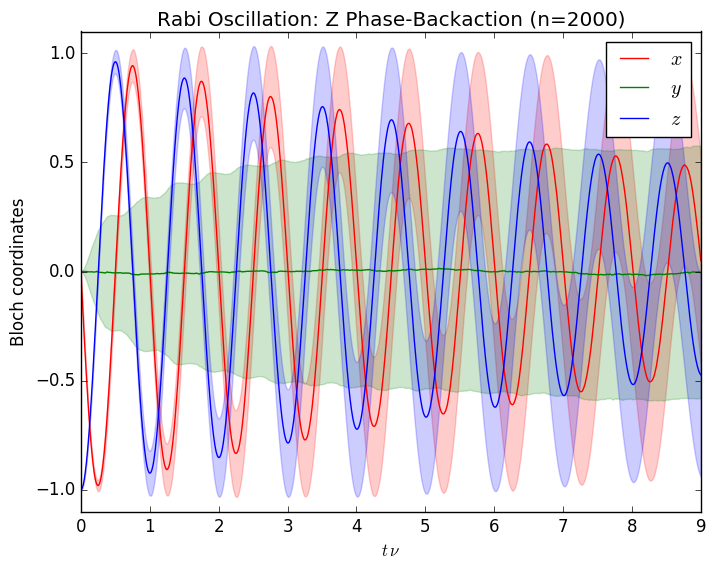

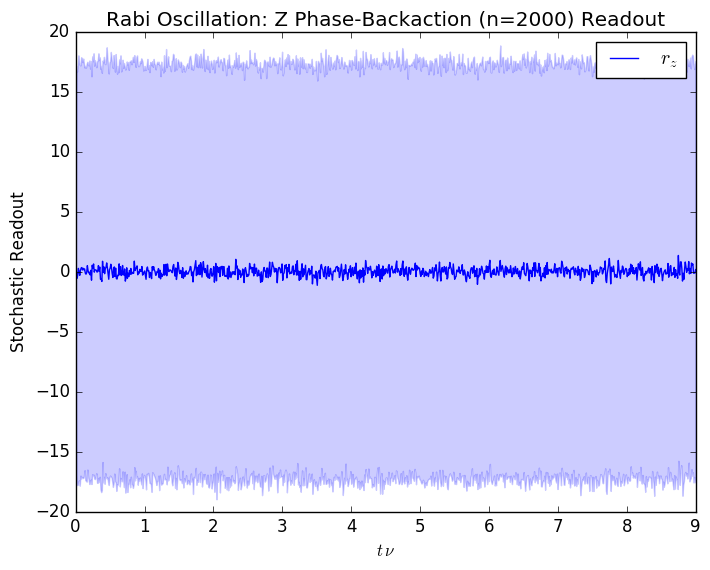

 38.788581 seconds (1.51 M allocations: 147.686 MB, 0.14% gc time)


INFO: Time elapsed: 38.726278477 s, Steps: 1798000, Steps per second: 46428.4220098209


In [25]:
e = ensemble_realization(n=2, ϕ=π/2) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Z Phase-Backaction (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 0.067423221 s, Steps: 1798, Steps per second: 26667.370281820262
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


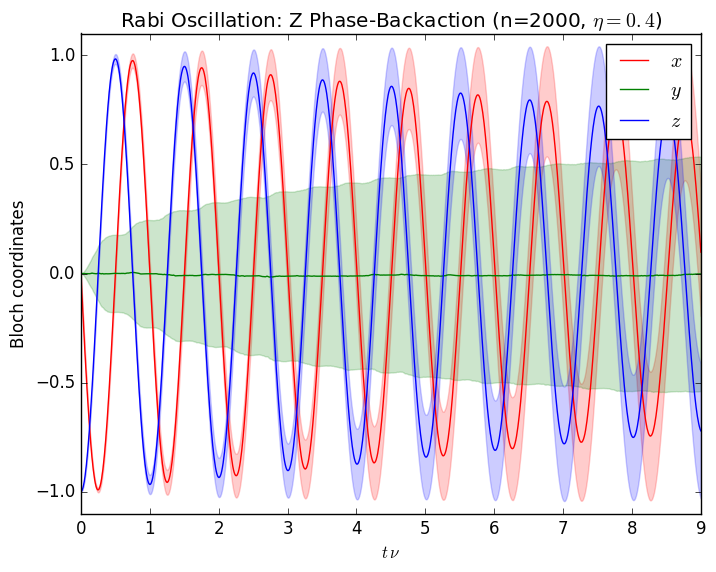

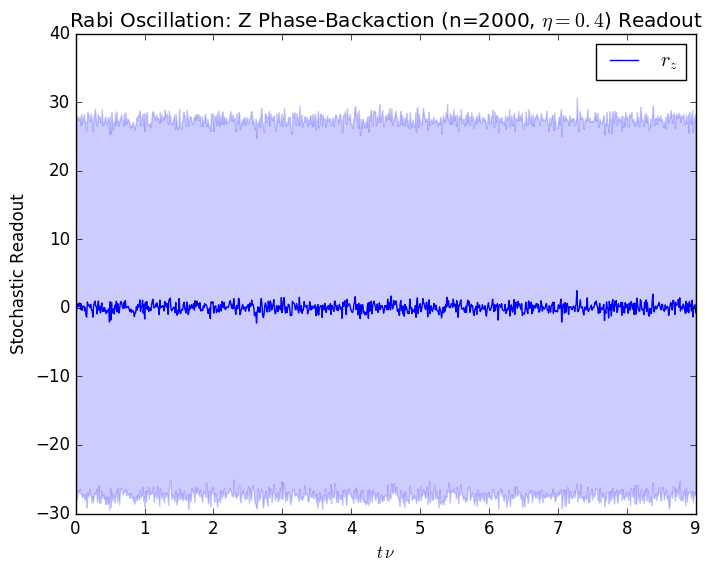

 37.304379 seconds (1.51 M allocations: 147.685 MB, 0.09% gc time)


In [26]:
e = ensemble_realization(n=2, ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Z Phase-Backaction (n=$num, \$\\eta=0.4\$)"))

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2
INFO: Time elapsed: 0.23035082 s, Steps: 1798, Steps per second: 7805.485563281259
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


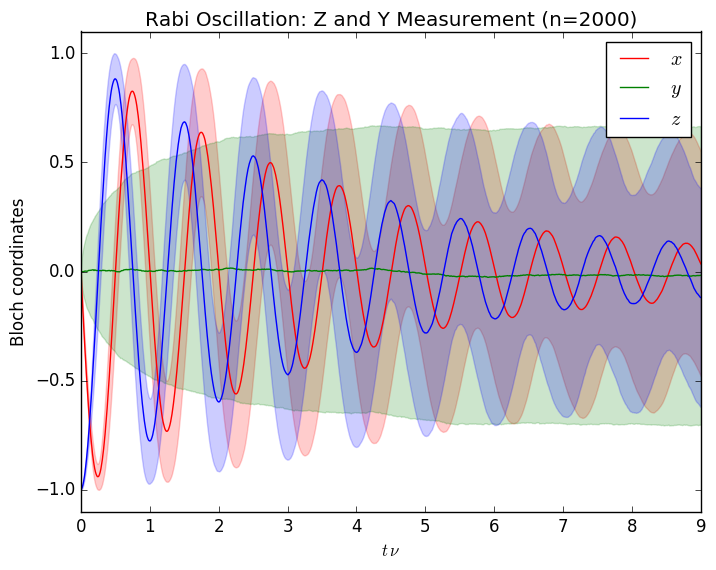

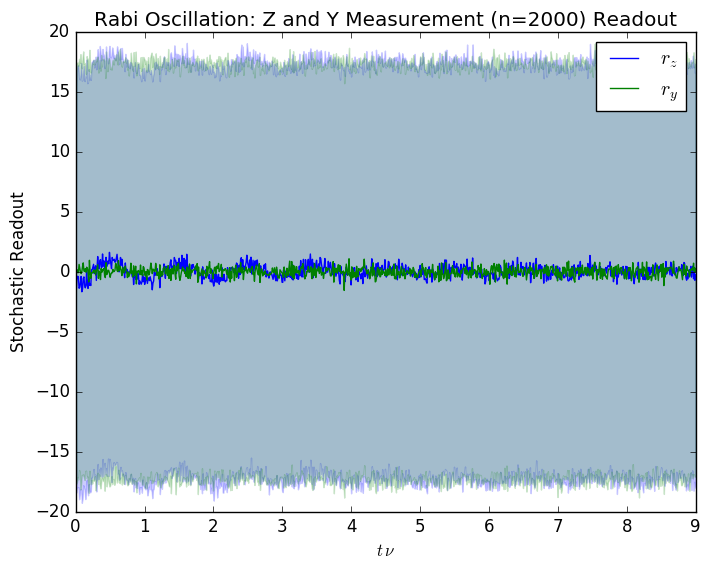

 61.951985 seconds (1.88 M allocations: 182.962 MB, 0.17% gc time)


In [27]:
e = ensemble_realization(n=2, ymeas=true) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Measurement (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2
INFO: Time elapsed: 0.053548291 s, Steps: 1798, Steps per second: 33577.168690593695
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


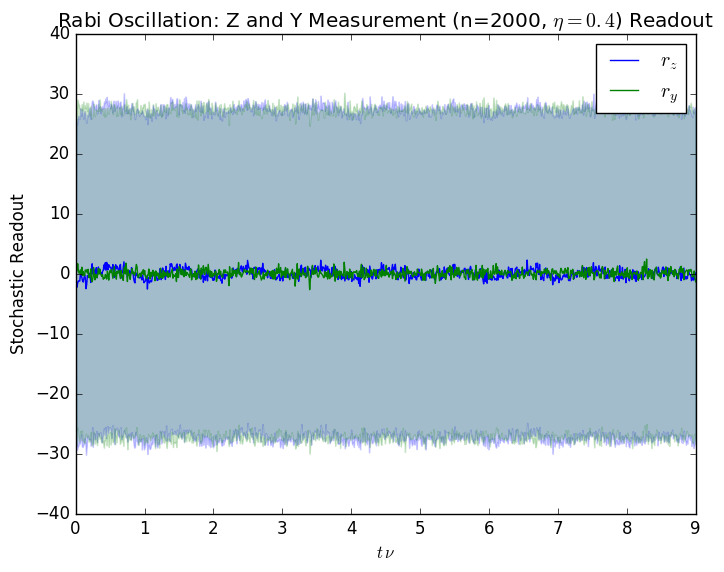

 50.676107 seconds (1.88 M allocations: 182.953 MB, 0.22% gc time)


INFO: Time elapsed: 50.536942008 s, Steps: 1798000, Steps per second: 35577.934250857055


In [28]:
e = ensemble_realization(n=2, ymeas=true, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title=latexstring("Rabi Oscillation: Z and Y Measurement (n=$num, \$\\eta = 0.4\$)"))

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2
INFO: Time elapsed: 0.081409974 s, Steps: 1798, Steps per second: 22085.74590626942
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


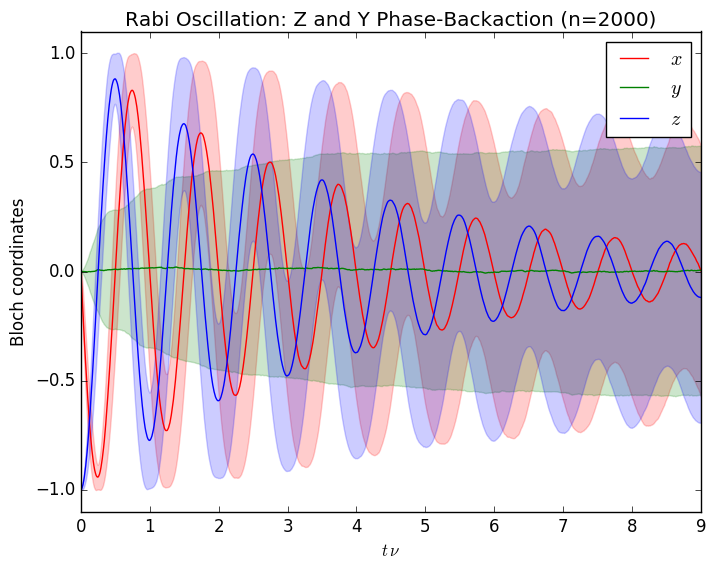

 49.295023 seconds (1.88 M allocations: 182.940 MB, 0.21% gc time)


In [29]:
e = ensemble_realization(n=2, ymeas=true, ϕ=π/2) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Phase-Backaction (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2
INFO: Time elapsed: 0.083227122 s, Steps: 1798, Steps per second: 21603.534482425093
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


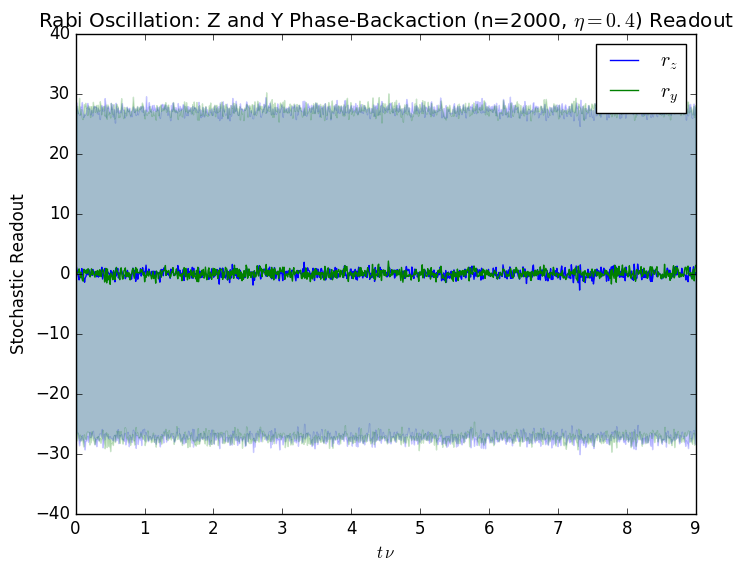

 46.977381 seconds (1.88 M allocations: 182.939 MB, 0.22% gc time)


In [30]:
e = ensemble_realization(n=2, ymeas=true, ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title=latexstring("Rabi Oscillation: Z and Y Phase-Backaction (n=$num, \$\\eta = 0.4\$)"))

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 0.70736883 s, Steps: 1798, Steps per second: 2541.8140067042536
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


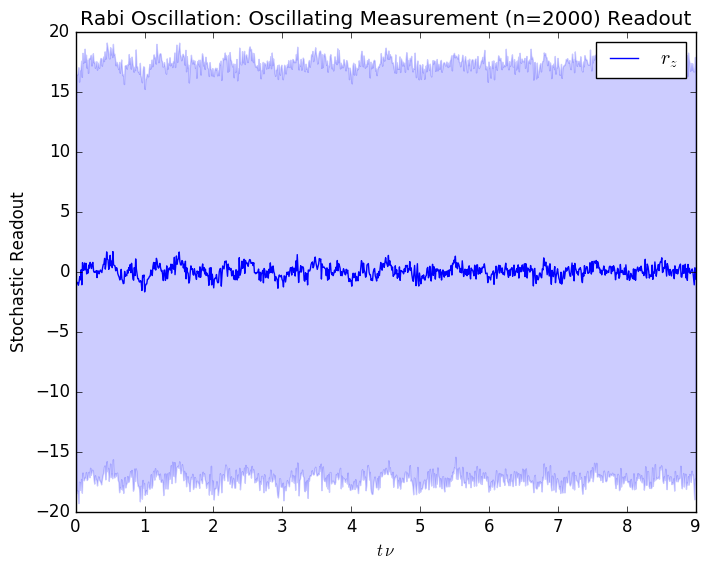

136.322297 seconds (1.32 M allocations: 144.271 MB, 0.03% gc time)


In [31]:
e = ensemble_realization(n=2, tmeas=true) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Oscillating Measurement (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 0.267532258 s, Steps: 1798, Steps per second: 6720.684875316979
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


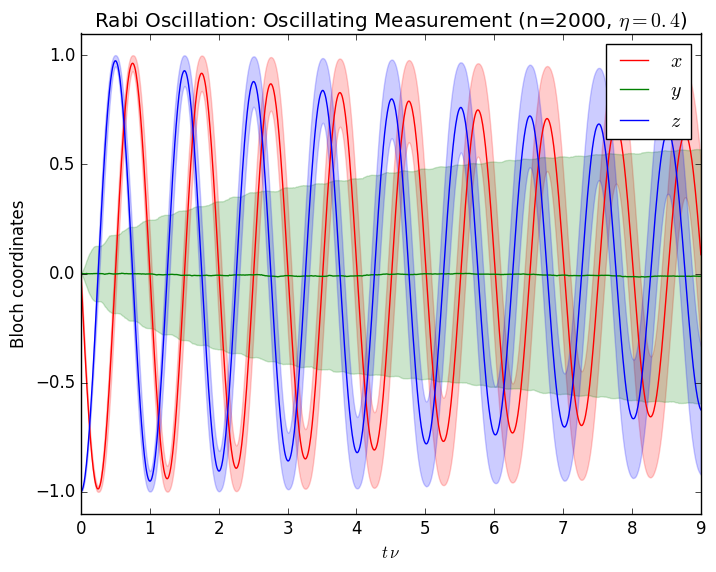

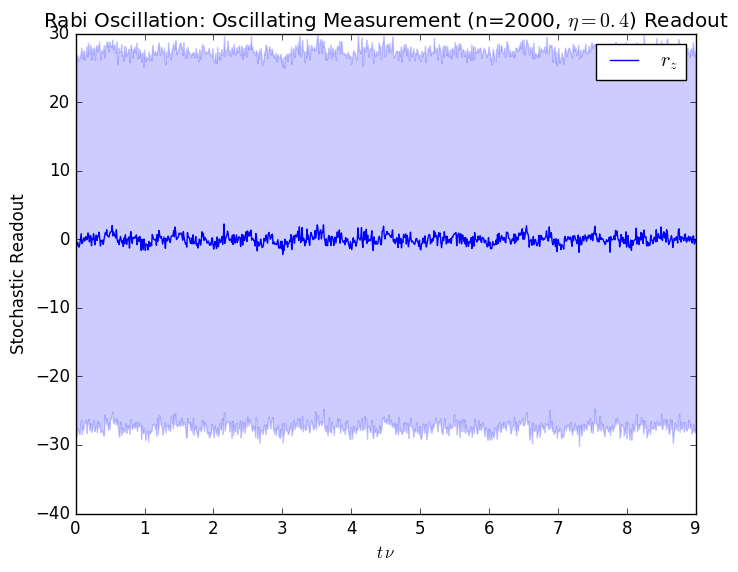

133.063591 seconds (1.31 M allocations: 144.286 MB, 0.08% gc time)


INFO: Time elapsed: 132.959045309 s, Steps: 1798000, Steps per second: 13522.961117999945


In [32]:
e = ensemble_realization(n=2, tmeas=true, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Oscillating Measurement (n=$num, \$\\eta = 0.4\$)"))

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 0.238520345 s, Steps: 1798, Steps per second: 7538.141033629647
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


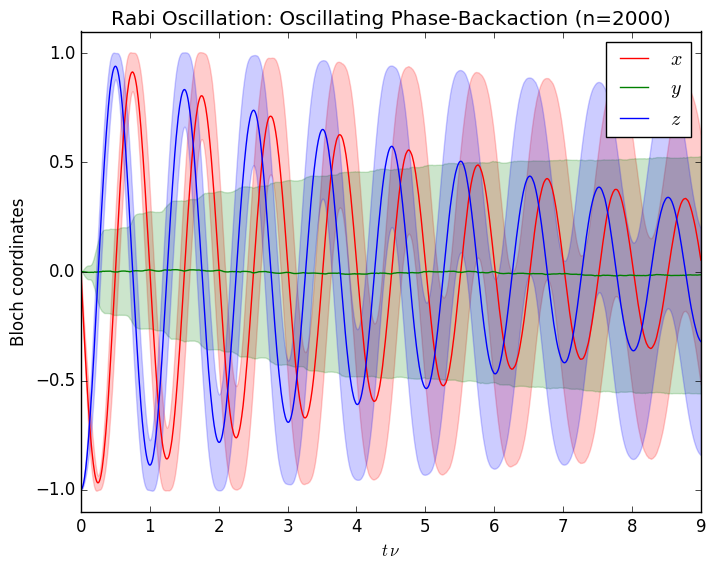

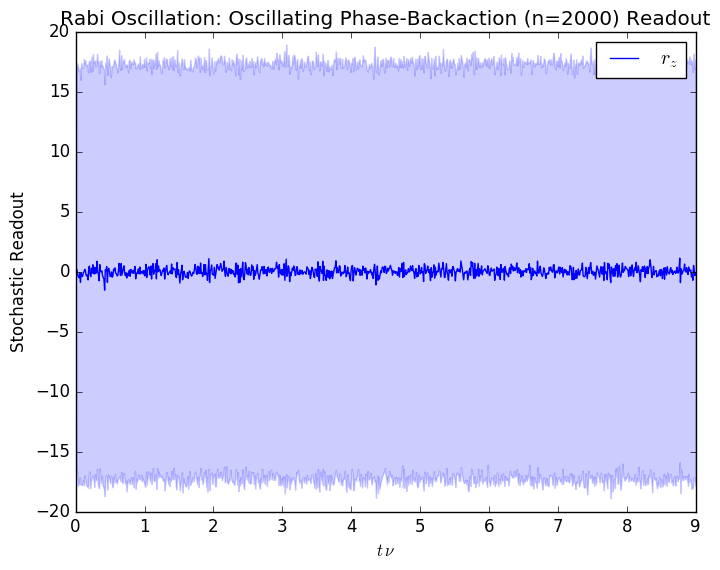

133.999207 seconds (1.31 M allocations: 144.290 MB, 0.03% gc time)


In [33]:
e = ensemble_realization(n=2, tmeas=true, ϕ=π/2) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Oscillating Phase-Backaction (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 0.282143865 s, Steps: 1798, Steps per second: 6372.635463826229
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


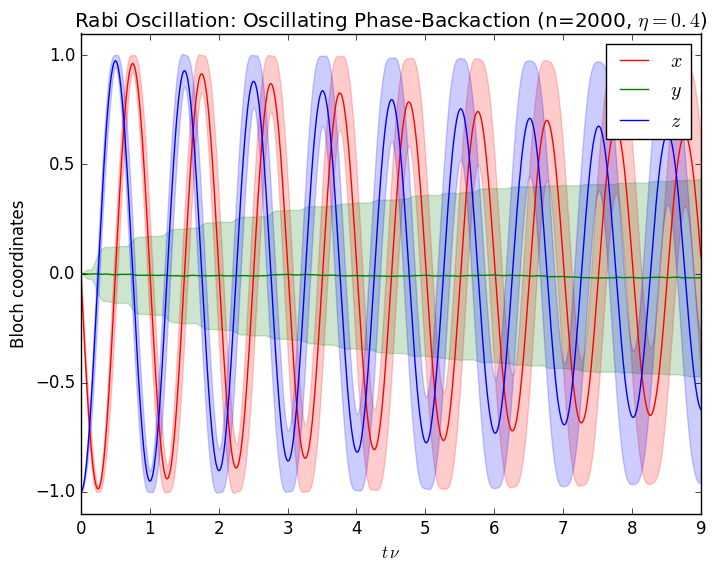

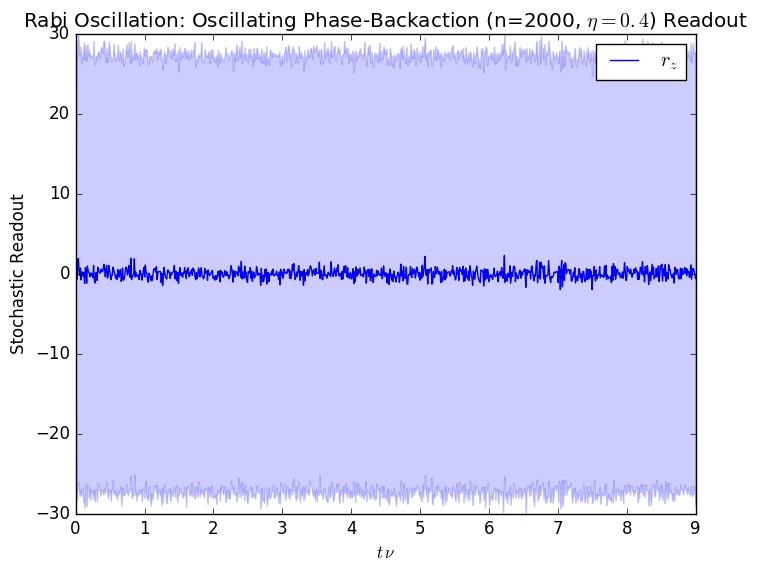

133.052542 seconds (1.31 M allocations: 144.289 MB, 0.03% gc time)


INFO: Time elapsed: 133.000429095 s, Steps: 1798000, Steps per second: 13518.753377221954


In [34]:
e = ensemble_realization(n=2, tmeas=true, ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Oscillating Phase-Backaction (n=$num, \$\\eta = 0.4\$)"))

## Conclusions

The Quantum Bayesian method for computing stochastic evolution works well and is competitive in speed with the direct Lindblad integration. It is both dramatically faster and much more accurate than any of the currently available stochastic integration solvers in the ```DifferentialEquations``` package.

## Version Information

In [35]:
versioninfo()

Julia Version 0.5.0
Commit 3c9d753 (2016-09-19 18:14 UTC)
Platform Info:
  System: Linux (x86_64-linux-gnu)
  CPU: Intel(R) Core(TM) i7-6560U CPU @ 2.20GHz
  WORD_SIZE: 64
  BLAS: libopenblas (NO_LAPACKE DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: liblapack.so.3
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, broadwell)


In [36]:
Pkg.installed("PyPlot")

v"2.2.4"

In [37]:
Pkg.installed("QuantumBayesian")

v"0.1.0+"

In [38]:
Pkg.installed("Interpolations")

v"0.3.6"